In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from symb_xai.lrp.symbolic_xai import TransformerSymbXAI, BERTSymbXAI
from symb_xai.model.transformer import tiny_transformer_with_3_layers, bert_base_uncased_model
from symb_xai.model.utils import load_pretrained_weights
from transformers import BertTokenizer
from dgl.data import SSTDataset

from symb_xai.visualization.utils import html_heatmap, make_text_string
from IPython.display import display, HTML, Latex


import torch

/opt/miniconda3/envs/symb_xai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from itertools import chain, combinations

def powerset(s):
    "powerset([1,2,3]) --> [[1], [2], [3], [1,2], [1,3], [2,3], [1,2,3]" 
    out = chain.from_iterable( combinations(s, r) for r in range(len(s)+1))
    return [list(elem) for elem in out if list(elem) != []] # no empty set


In [8]:
large_model = True
# Create model.
if not large_model:
    model = tiny_transformer_with_3_layers(
        pretrained_model_name_or_path="textattack/bert-base-uncased-SST-2"
    )
    # Load pre-trained weights.
    load_pretrained_weights(
        model,
        '../saved_models/sst2-3layer-model.pt'
    )
else:
    model = bert_base_uncased_model(
        pretrained_model_name_or_path='textattack/bert-base-uncased-SST-2'
    )

model.eval()
pretrained_embeddings = model.bert.embeddings





Full:  [CLS] huge explosions and loud shooting, this is exactly what i like. [SEP]
X: huge explosions and loud shooting
Y: this is exactly what i like
Z: [CLS],. [SEP]




<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

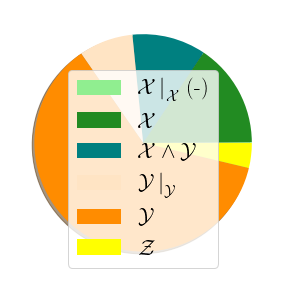

check conservation:  1.000000011540468 1.0


Full:  [CLS] huge explosions and loud shooting, please no, what a poor imitation. [SEP]
X: huge explosions and loud shooting
Y: please no, what a poor imitation
Z: [CLS],. [SEP]




<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

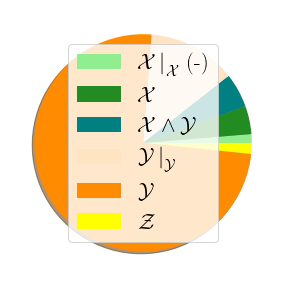

check conservation:  1.0000000115758305 1.0


Full:  [CLS] this movie showed thousands of little pup ##pies, i love little pup ##pies ! [SEP]
X: this movie showed thousands of little pup ##pies
Y: i love little pup ##pies
Z: [CLS], ! [SEP]




<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

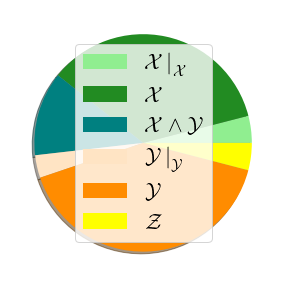

check conservation:  0.9999998883042257 1.0




In [24]:
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['text.usetex'] = True

font = {'family': 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)

sents = {}
targets = {}
X = {}
Y = {}

verbose=True

sents[0] = "Huge explosions and loud shooting, this is exactly what I like."
sents[1] = "Huge explosions and loud shooting, please no, what a poor imitation."
sents[2] = "This movie showed thousands of little puppies, I love little puppies!"
# sents[3] = "This movie showed thousands of little puppies, I hate little puppies!"

targets[0] = torch.tensor([-1,1])
targets[1] = torch.tensor([-1,1])
targets[2] = torch.tensor([-1,1])
# targets[3] = torch.tensor([-1,1])

X[0] = [1,2,3,4,5]
X[1] = [1,2,3,4,5]
X[2] = [1,2,3,4,5,6,7,8]
# X[3] = [1,2,3,4,5,6,7,8]

Y[0] = [7,8,9,10,11,12]
Y[1] = [7,8,9,10,11,12,13]
Y[2] = [10,11,12,13,14]
# Y[3] = [10,11,12,13,14]




###### 
embeddings = model.bert.embeddings
tokenizer = BertTokenizer.from_pretrained("textattack/bert-base-uncased-SST-2")

samples = {ids: tokenizer(sent, return_tensors="pt") for ids,sent in sents.items()}

sent_tokens = {ids: tokenizer.convert_ids_to_tokens(sample['input_ids'].squeeze())
               for ids,sample in samples.items()}
Z = {}
for ids, sent_token in sent_tokens.items():
    token_ids = list(range(len(sent_token)))
    token_ids = [tok for tok in token_ids if not( tok in X[ids] or tok in Y[ids])]
    Z[ids] = token_ids

explainers = {ids: BERTSymbXAI(sample, target, model, pretrained_embeddings) if large_model 
              else TransformerSymbXAI(sample, target, model, embeddings) 
               for (ids,sample), (_,target) in zip(samples.items(), targets.items()) }


# Specify the queries
for idn, ids in enumerate(sents.keys()):
    if verbose:
        print('Full: ', make_text_string(sent_tokens[ids]))
#         for ids, (tX,tY,tZ) in enumerate(zip(X.values(), Y.values(), Z.values())):
        print('X:', make_text_string([sent_tokens[ids][x] for x in X[ids]]))
        print('Y:', make_text_string([sent_tokens[ids][y] for y in Y[ids]]))
        print('Z:', make_text_string([sent_tokens[ids][z] for z in Z[ids]]))
        print('\n')

    
    qks = {'$\\mathcal{X}\\, \\big|_{\\mathcal{X}}$' : lambda l: l == [X[ids]],
           '$\\mathcal{X}$' : lambda l: X[ids] in l,
          '$\\mathcal{X} \wedge \\mathcal{Y}$' :lambda l: (X[ids] in l) and (Y[ids] in l),
          '$\\mathcal{Y}\\, \\big|_{\\mathcal{Y}}$' : lambda l: l == [Y[ids]],
          '$\\mathcal{Y}$' : lambda l: Y[ids] in l,
          '$\\mathcal{Z}$' :lambda l: l == [Z[ids]] }
    colors = {
        '$\\mathcal{X}\\, \\big|_{\\mathcal{X}}$' : 'lightgreen',
           '$\\mathcal{X}$' : 'forestgreen',
          '$\\mathcal{X} \wedge \\mathcal{Y}$' : 'teal',
          '$\\mathcal{Y}\\, \\big|_{\\mathcal{Y}}$' : 'bisque',
          '$\\mathcal{Y}$' : 'darkorange',
          '$\\mathcal{Z}$' : 'yellow'
    }


    pow_s = powerset([X[ids],Y[ids],Z[ids]])
    explainer = explainers[ids]


    def attribute(qk,pow_s, qks):
        out = 0.
        for l in pow_s:
            flat_l = [item for sublist in l for item in sublist]

            harsanyi_div = explainer.symb_and(l, context=flat_l)
            eta_l = 1/sum([float(q(l)) for q in qks.values() ])

            out += eta_l * harsanyi_div * float(qk(l))

        return out.item()

    full_out = 0.
    full_quantity = explainer.subgraph_relevance(list(range(len(sent_tokens[ids])))).item()
    atts = {}
    for key, qk in qks.items():
        atts[key] = attribute(qk, pow_s, qks)/full_quantity 
        full_out += atts[key]
        display(Latex(key + ' $\\rightarrow '+ str(round(atts[key], 3)) + '$'))
    
    fig, ax = plt.subplots(figsize=(6,5))
    aat, keys, cols = [],[],[]
    
    for at, key in zip(atts.values(),atts.keys()):
        cols.append(colors[key])
        
        if at<0:
            key += ' (-)'
        aat.append(abs(at))
        keys.append(key)
        
    patches, texts = ax.pie(aat, colors=cols, shadow=False)
    plt.legend(patches, keys, loc="best")
    plt.savefig('../pics/pie_plot_synth_nlp_ids{0}.svg'.format(idn))
    plt.show()
    
    print('check conservation: ', 
          full_out, 
          explainer.subgraph_relevance(list(range(len(sent_tokens[ids])))).item()/full_quantity
    )
    print('\n')



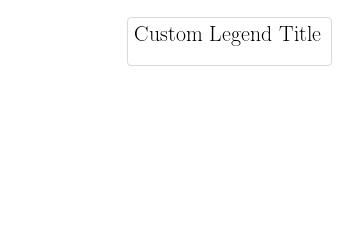

In [22]:
import matplotlib.pyplot as plt

# Create a legend without any associated plot elements
legend_labels = ['Label 1', 'Label 2', 'Label 3']

# Create a figure and axis (you can adjust the figure size as needed)
fig, ax = plt.subplots(figsize=(6, 4))

# Create the legend without any plot elements
legend = ax.legend(legend_labels, loc='upper right')

# Turn off the axis so it's not visible in the saved image
ax.axis('off')

# Optionally, you can customize the legend's appearance
legend.get_frame().set_alpha(0.7)  # Adjust the legend's background transparency
legend.set_title('Custom Legend Title')  # Set a legend title

# Save the legend as an image (e.g., PNG)
plt.savefig('custom_legend.png', bbox_inches='tight', dpi=300)

# Show the legend (optional)
plt.show()


In [ ]:
# sents = {}
# targets = {}
# query_ids = {}
# contexts = {}
# # sents[0] = "Sandra Bullock is usually a good actress, but this time she wasn’t."
# # sents[1] = "Great to see that this time Sandra Bullock wasn’t acting strange."
# sents[2] = "Huge explosions and loud shooting, this is exactly what I like."
# sents[3] = "Huge explosions and loud shooting, please no, what a poor imitation."

# # targets[0] = torch.tensor([-1,1])
# # targets[1] = torch.tensor([-1,1])
# targets[2] = torch.tensor([-1,1])
# targets[3] = torch.tensor([-1,1])

# # query_ids[0] = [10,11,13,14,15]
# # query_ids[1] = [5,6,9,10,11]
# query_ids[2] = [1,2,3,4,5]
# query_ids[3] = [1,2,3,4,5]

# # contexts[0] = [3,4,5,6,7]
# # contexts[1] = [12,13]
# contexts[2] = [7,8,9,10,11,12]
# contexts[3] = [7,8,9,10,11,12,13]
# ###### 
# embeddings = model.bert.embeddings
# tokenizer = BertTokenizer.from_pretrained("textattack/bert-base-uncased-SST-2")

# samples = {ids: tokenizer(sent, return_tensors="pt") for ids,sent in sents.items()}
# # sample1 = 
# # sample2 = tokenizer(sent2, return_tensors="pt")
# sent_tokens = {ids: tokenizer.convert_ids_to_tokens(sample['input_ids'].squeeze())
#                for ids,sample in samples.items()}


# # sent_tokens1 = 
# # sent_tokens2 = tokenizer.convert_ids_to_tokens(sample2['input_ids'].squeeze())
# explainers = {ids: BERTSymbXAI(sample, target, model, pretrained_embeddings) if large_model 
#               else TransformerSymbXAI(sample, target, model, embeddings) 
#                for (ids,sample), (_,target) in zip(samples.items(), targets.items()) }
# # explainer1 = 
# # explainer2 = TransformerSymbXAI(sample2, target2, model, embeddings)


# for explainer, tokens, sample, sent, context, query_id in zip(explainers.values(),
#                                                     sent_tokens.values(), 
#                                                     samples.values(), 
#                                                     sents.values(),
#                                                    contexts.values(),
#                                                    query_ids.values()):
#     print( 
#       '"'+ sent +'"', 
#       '----> ', 'positive' if model(**sample)['logits'].argmax() == 1 else 'negative')
    
#     display(Latex('$\\mathcal{R}(I|\\,  \\mathcal{N})$'))
#     display(HTML(html_heatmap(tokens, [explainer.symb_or([feat]) for feat in range(len(tokens))])))
#     display(Latex('$\\mathcal{R}(I|\\,  \\{I\\})$'))
#     display(HTML(html_heatmap(tokens, [explainer.symb_or([feat], context=[feat]) for feat in range(len(tokens))])))
    
#     print(f'subsent', '"' + make_text_string([tokens[ids] for ids in query_id]) +'"',
#           'with context', '"' +make_text_string([tokens[ids] for ids in context]) +'"',
#           ' val: ', explainer.symb_or(query_id, context=query_id+context).item())
    
#     print(f'subsent', '"' + make_text_string([tokens[ids] for ids in query_id]) +'"',
#           'with full context',
#           ' val: ', explainer.symb_or(query_id, context=None).item())
    
#     print(f'subsent', '"' + make_text_string([tokens[ids] for ids in query_id]) +'"',
#           'without context',
#           ' val: ', explainer.symb_or(query_id, context=query_id).item())
#     print(f'context', '"' + make_text_string([tokens[ids] for ids in context]) +'"',
#           'without context',
#           ' val: ', explainer.symb_or(context, context=context).item())
#     print(f'context', '"' + make_text_string([tokens[ids] for ids in context]) +'"',
#           'with full context',
#           ' val: ', explainer.symb_or(context, context=None).item())  
#     print('full contribution:', explainer.symb_or(list(range(len(tokens))), context=None).item() )
#     print('\n')
    


In [ ]:
# sents = {}
# targets = {}
# subsent1 = {}
# subsent2 = {}

# sents[0] = "This movie showed thousands of little puppies, I love little puppies!"
# sents[1] = "This movie showed thousands of little puppies, I hate little puppies!"


# targets[0] = torch.tensor([-1,1])
# targets[1] = torch.tensor([-1,1])


# subsent1[0] = [1,2,3,4,5,6,7,8]
# subsent1[1] = [1,2,3,4,5,6,7]


# subsent2[0] = [10,11,12,13,14]
# subsent2[1] = [10,11,12,13,14]

# ###### 
# embeddings = model.bert.embeddings
# tokenizer = BertTokenizer.from_pretrained("textattack/bert-base-uncased-SST-2")

# samples = {ids: tokenizer(sent, return_tensors="pt") for ids,sent in sents.items()}

# sent_tokens = {ids: tokenizer.convert_ids_to_tokens(sample['input_ids'].squeeze())
#                for ids,sample in samples.items()}

# explainers = {ids: BERTSymbXAI(sample, target, model, pretrained_embeddings) if large_model 
#               else TransformerSymbXAI(sample, target, model, embeddings) 
#                for (ids,sample), (_,target) in zip(samples.items(), targets.items()) }

# for explainer, tokens, sample, sent, sent1, sent2 in zip(explainers.values(),
#                                                     sent_tokens.values(), 
#                                                     samples.values(), 
#                                                     sents.values(),
#                                                    subsent1.values(),
#                                                    subsent2.values()):
#     print( 
#       '"'+ sent +'"', 
#       '----> ', 'positive' if model(**sample)['logits'].argmax() == 1 else 'negative')
    
#     display(Latex('$\\mathcal{R}(I|\\,  \\mathcal{N})$'))
#     display(HTML(html_heatmap(tokens, [explainer.symb_or([feat]) for feat in range(len(tokens))])))
#     display(Latex('$\\mathcal{R}(I|\\,  \\{I\\})$'))
#     display(HTML(html_heatmap(tokens, [explainer.symb_or([feat], context=[feat]) for feat in range(len(tokens))])))
    
#     print(f'subsent', '"' + make_text_string([tokens[ids] for ids in sent1]) +'"',
#           'and subent', '"' +make_text_string([tokens[ids] for ids in sent2]) +'"',
#           ' val: ', explainer.symb_and([sent1,sent2], context=None).item())

#     print(f'sent1', '"' + make_text_string([tokens[ids] for ids in sent1]) +'"',
#           'without context',
#           ' val: ', explainer.symb_or(sent1, context=sent1).item())
#     print(f'sent2', '"' + make_text_string([tokens[ids] for ids in sent2]) +'"',
#           'without context',
#           ' val: ', explainer.symb_or(sent2, context=sent2).item())
#     print(f'sent1', '"' + make_text_string([tokens[ids] for ids in sent1]) +'"',
#           'with full contntext',
#           ' val: ', explainer.symb_or(sent1, context=None).item())
#     print(f'sent2', '"' + make_text_string([tokens[ids] for ids in sent2]) +'"',
#           'with full context',
#           ' val: ', explainer.symb_or(sent2, context=None).item())
#     print('full contribution:', explainer.symb_or(list(range(len(tokens))), context=None).item() )

#     print('\n')
    
